In [1]:
%pylab inline
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
type(X_train), X_train.shape

(numpy.ndarray, (60000, 28, 28))

In [4]:
t = np.random.randint(0, 100, size=32)

t

Y_train.shape

(60000,)

(<matplotlib.image.AxesImage at 0x11bae59a0>, 5)

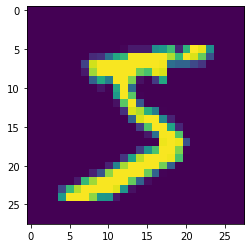

In [5]:
plt.imshow(X_train[0]), Y_train[0]

In [20]:
import torch.nn as nn

net = nn.Linear(2, 1)
print('network structure : torch.nn.Linear(2,1) :\n',net)

print('Weight of network :\n',net.weight)

print('Bias of network :\n',net.bias)


network structure : torch.nn.Linear(2,1) :
 Linear(in_features=2, out_features=1, bias=True)
Weight of network :
 Parameter containing:
tensor([[ 0.1594, -0.5883]], requires_grad=True)
Bias of network :
 Parameter containing:
tensor([0.5928], requires_grad=True)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # 1 layer NN, 784 inputs, 128 outputs. Bias: 128, Weights: matrix of 128 row 784 colmns (tensor)
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.l1(x)
        x = F.R(x)
        x = self.l2(x)
        return x

loss  0.30, accuracy  0.88: 100%|██████████| 1000/1000 [00:02<00:00, 400.27it/s]


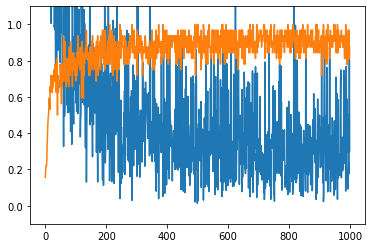

In [8]:
batch = 32
loss_f = nn.CrossEntropyLoss()

m = SimpleNet()
adam_optimizer = torch.optim.Adam(m.parameters())
sgd_optimizer = torch.optim.SGD(m.parameters(), lr=0.001, momentum=0)


losses, accuracies = [], []

for i in ( j:= trange(1000)):
    t = np.random.randint(0, X_train.shape[0], size=(batch))
    x = torch.tensor(X_train[t].reshape((-1, 28*28))).float()
    y = torch.tensor(Y_train[t]).long()
    #########################
    #adam_optimizer.zero_grad()
    sgd_optimizer.zero_grad()
    #########################
    out = m(x)
    ac = torch.argmax(out, dim=1)
    accuracy = (ac == y).float().mean()
    loss = loss_f(out, y)
    loss.backward()
    ####################
    #adam_optimizer.step()
    sgd_optimizer.step()
    ####################
    l, a = loss.item(), accuracy.item()
    losses.append(l)
    accuracies.append(a)
    j.set_description(f"loss {l: .2f}, accuracy {a: .2f}")
    
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [9]:
y_test_preds = torch.argmax(m(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == y_test_preds).mean()

0.9154

In [13]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 5040776256, 5041210272)

In [16]:
l1[:] = m.l1.weight.detach().numpy().transpose()
l2[:] = m.l2.weight.detach().numpy().transpose()

In [19]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x
Y_test_preds = np.argmax(forward(X_test.reshape((-1, 28*28))), axis=1)
(Y_test == Y_test_preds).mean()

0.916